# Importing Libraries and Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import warnings

warnings.filterwarnings("ignore")


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    fxn()

In [3]:
# Load the training dataset
instagram_df_train=pd.read_csv('kaggle/input/Dataset_1/train.csv')
instagram_df_train

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.00,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.00,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.00,0,0,0,1,13,159,98,0
3,1,0.00,1,0.00,0,82,0,0,679,414,651,0
4,1,0.00,2,0.00,0,0,0,1,6,151,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1


In [4]:
# Load the testing data
instagram_df_test=pd.read_csv('kaggle/input/Dataset_1/test.csv')
instagram_df_test

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0
...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,1
116,1,0.40,1,0.00,0,0,0,0,4,150,164,1
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,1
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,1


# Statistical Analysis

In [5]:
instagram_df_train.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [6]:
instagram_df_train.tail()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1
575,1,0.27,1,0.00,0,0,0,0,2,150,487,1


In [7]:
# Getting dataframe info
instagram_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


In [8]:
# Get the statistical summary of the dataframe
instagram_df_train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [9]:
# Get the number of unique values in the "profile pic" feature
instagram_df_train['profile pic'].value_counts()

profile pic
1    404
0    172
Name: count, dtype: int64

In [10]:
# Get the number of unique values in "fake" (Target column)
instagram_df_train['fake'].value_counts()

fake
0    288
1    288
Name: count, dtype: int64

# Data Visualization

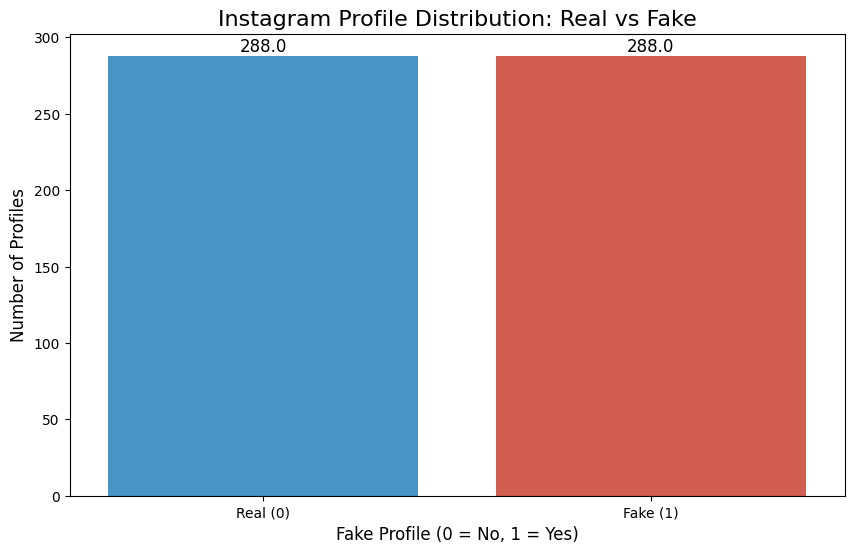

In [11]:
# Visualization of real vs fake profiles distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='fake', data=instagram_df_train, palette=['#3498db', '#e74c3c'])
plt.title('Instagram Profile Distribution: Real vs Fake', fontsize=16)
plt.xlabel('Fake Profile (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Profiles', fontsize=12)
# Add values on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)

plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.show()

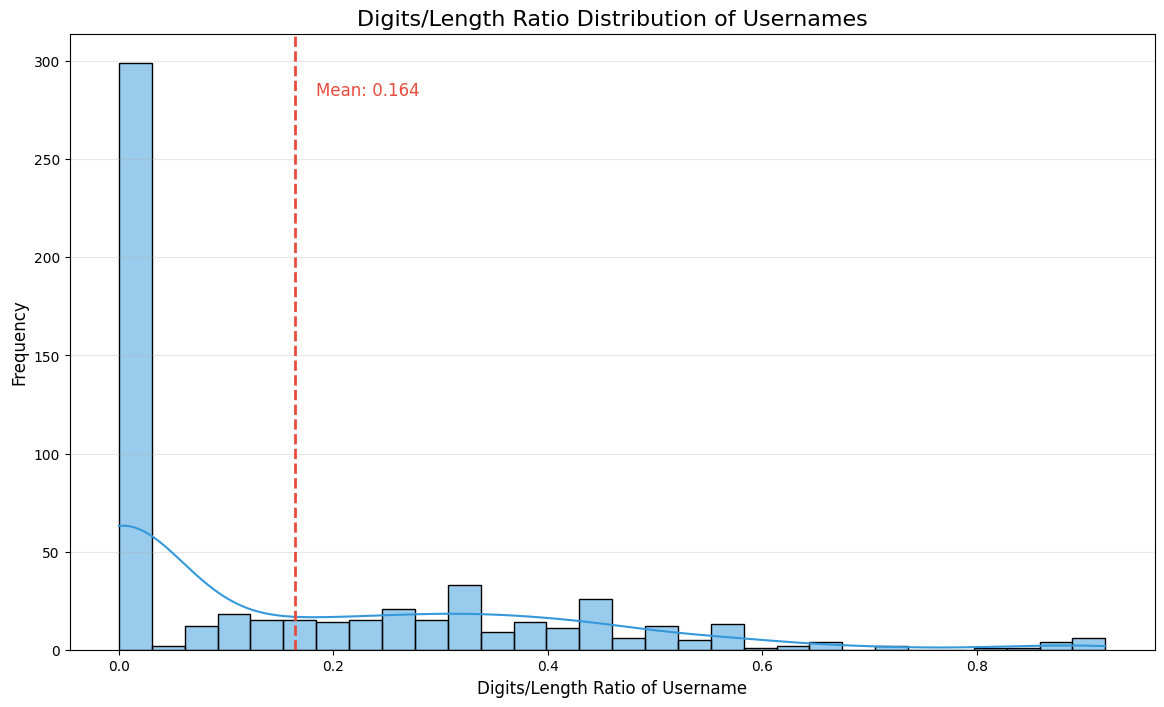

In [12]:
# Visualization of the digits/length ratio distribution of usernames
plt.figure(figsize = (14, 8))
ax = sns.histplot(instagram_df_train['nums/length username'], bins=30, kde=True, color='#3498db')
plt.title('Digits/Length Ratio Distribution of Usernames', fontsize=16)
plt.xlabel('Digits/Length Ratio of Username', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add a vertical line for the mean
mean_val = instagram_df_train['nums/length username'].mean()
plt.axvline(x=mean_val, color='#e74c3c', linestyle='--', linewidth=2)
plt.text(mean_val + 0.02, plt.ylim()[1]*0.9, f'Mean: {mean_val:.3f}', color='#e74c3c', fontsize=12)

plt.show()

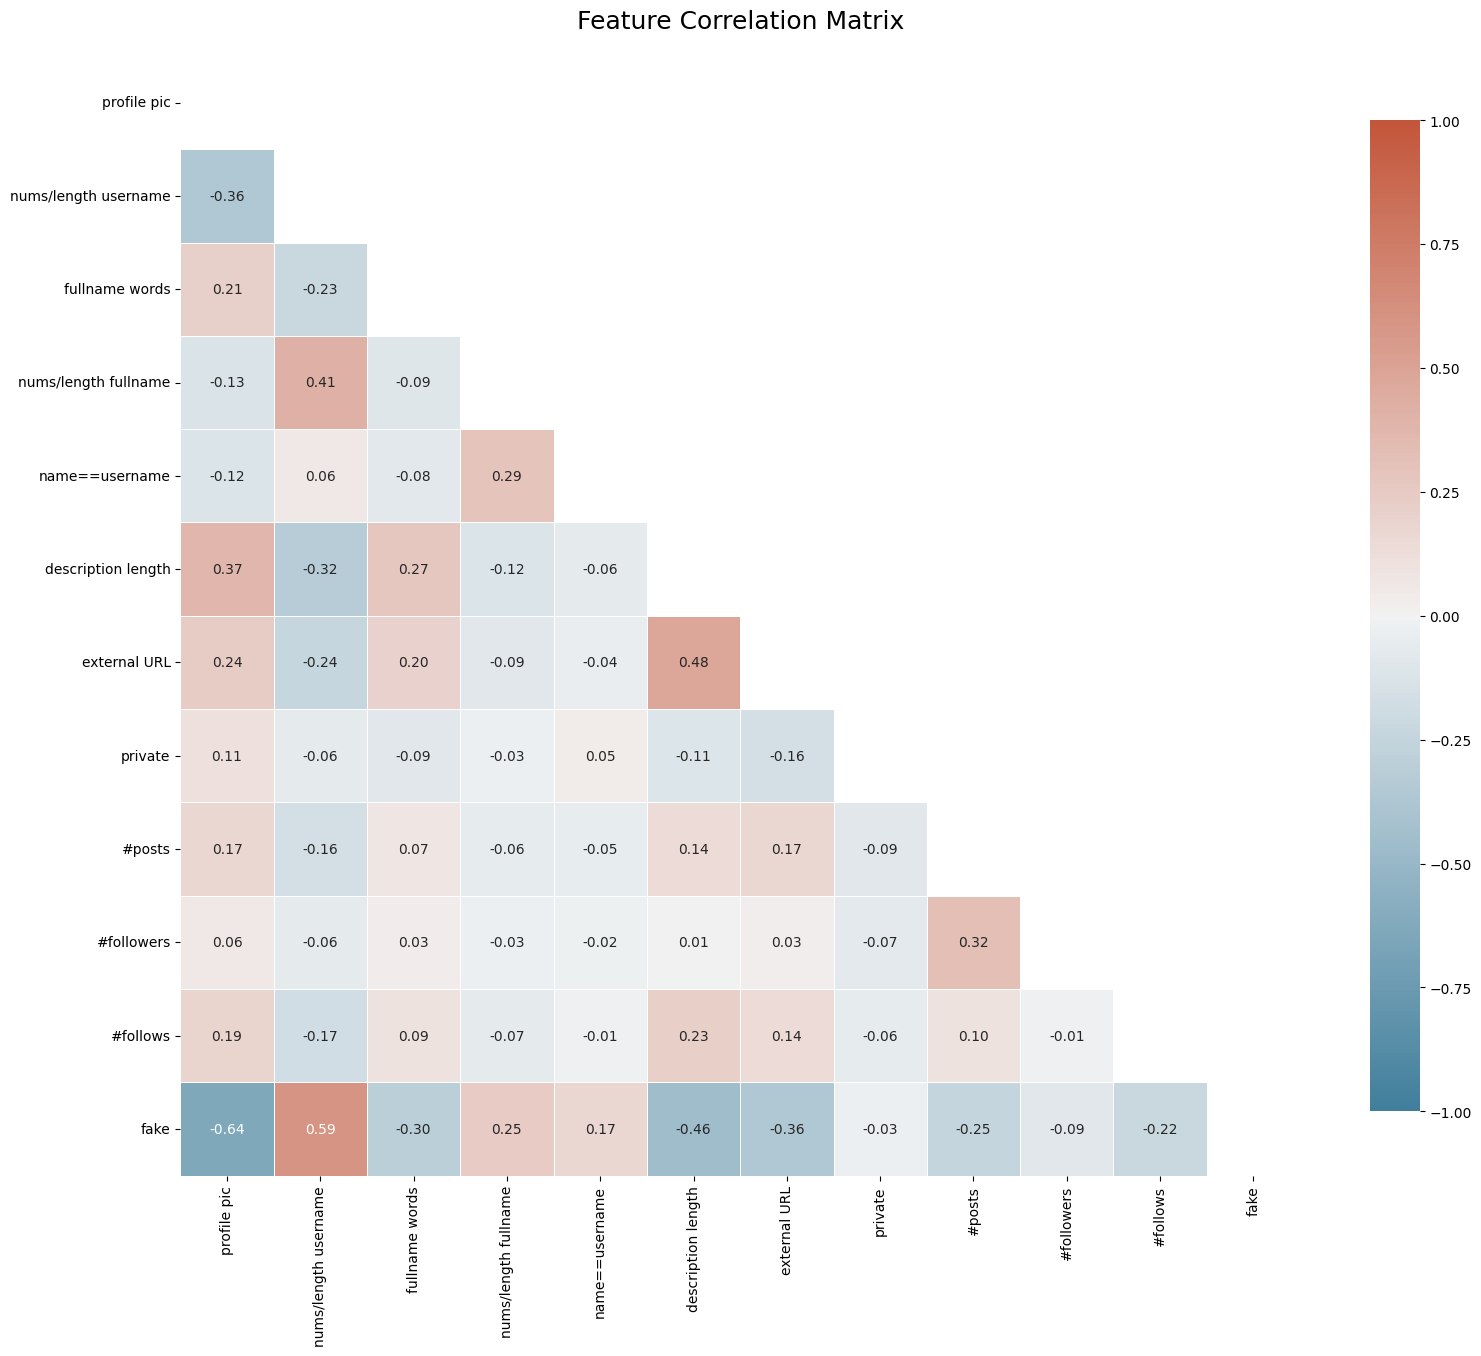

In [13]:
# Enhanced visualization of the correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(instagram_df_train.corr())
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(instagram_df_train.corr(), annot=True, fmt='.2f', cmap=cmap, linewidths=0.5, 
            mask=mask, vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

# Data Modelling

In [14]:
# Training and testing dataset (inputs)
X_train = instagram_df_train.drop(columns = ['fake'])
X_test = instagram_df_test.drop(columns = ['fake'])
X_train

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.00,0,53,0,0,32,1000,955
1,1,0.00,2,0.00,0,44,0,0,286,2740,533
2,1,0.10,2,0.00,0,0,0,1,13,159,98
3,1,0.00,1,0.00,0,82,0,0,679,414,651
4,1,0.00,2,0.00,0,0,0,1,6,151,126
...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596
572,1,0.38,1,0.33,0,21,0,0,44,66,75
573,1,0.57,2,0.00,0,0,0,0,4,96,339
574,1,0.57,1,0.00,0,11,0,0,0,57,73


In [15]:
# Training and testing dataset (Outputs)
y_train = instagram_df_train['fake']
y_test = instagram_df_test['fake']
y_train

0      0
1      0
2      0
3      0
4      0
      ..
571    1
572    1
573    1
574    1
575    1
Name: fake, Length: 576, dtype: int64

In [16]:
# Scale the data before training the model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Neural Network Model

In [17]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

In [18]:
# Convert labels to one-hot encoding
y_train_tensor = torch.zeros(len(y_train), 2)
y_train_tensor[range(len(y_train)), y_train.astype(int)] = 1
y_test_tensor = torch.zeros(len(y_test), 2)
y_test_tensor[range(len(y_test)), y_test.astype(int)] = 1

In [19]:
# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [20]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# PyTorch model definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=11):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 150)
        self.layer3 = nn.Linear(150, 150)
        self.layer4 = nn.Linear(150, 25)
        self.layer5 = nn.Linear(25, 2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.dropout(x)
        x = self.softmax(self.layer5(x))
        return x

In [22]:
# Create the model
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=11, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=150, bias=True)
  (layer3): Linear(in_features=150, out_features=150, bias=True)
  (layer4): Linear(in_features=150, out_features=25, bias=True)
  (layer5): Linear(in_features=25, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=1)
)


In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Training the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

In [25]:
# Validation split
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

In [26]:
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    history['train_loss'].append(epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    history['val_loss'].append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/50], Train Loss: 0.6847, Val Loss: 0.6638
Epoch [2/50], Train Loss: 0.6128, Val Loss: 0.5365
Epoch [3/50], Train Loss: 0.4944, Val Loss: 0.4280
Epoch [4/50], Train Loss: 0.4105, Val Loss: 0.4150
Epoch [5/50], Train Loss: 0.4024, Val Loss: 0.4248
Epoch [6/50], Train Loss: 0.4009, Val Loss: 0.4263
Epoch [7/50], Train Loss: 0.3990, Val Loss: 0.4252
Epoch [8/50], Train Loss: 0.3919, Val Loss: 0.4265
Epoch [9/50], Train Loss: 0.3860, Val Loss: 0.4205
Epoch [10/50], Train Loss: 0.3845, Val Loss: 0.4341
Epoch [11/50], Train Loss: 0.3926, Val Loss: 0.4316
Epoch [12/50], Train Loss: 0.3947, Val Loss: 0.4291
Epoch [13/50], Train Loss: 0.3892, Val Loss: 0.4320
Epoch [14/50], Train Loss: 0.3845, Val Loss: 0.4362
Epoch [15/50], Train Loss: 0.3828, Val Loss: 0.4198
Epoch [16/50], Train Loss: 0.3870, Val Loss: 0.4219
Epoch [17/50], Train Loss: 0.3869, Val Loss: 0.4281
Epoch [18/50], Train Loss: 0.3888, Val Loss: 0.4334
Epoch [19/50], Train Loss: 0.3828, Val Loss: 0.4278
Epoch [20/50], Train 

# # Neural Network Model Validation and Results

In [27]:
print(history.keys())

dict_keys(['train_loss', 'val_loss'])


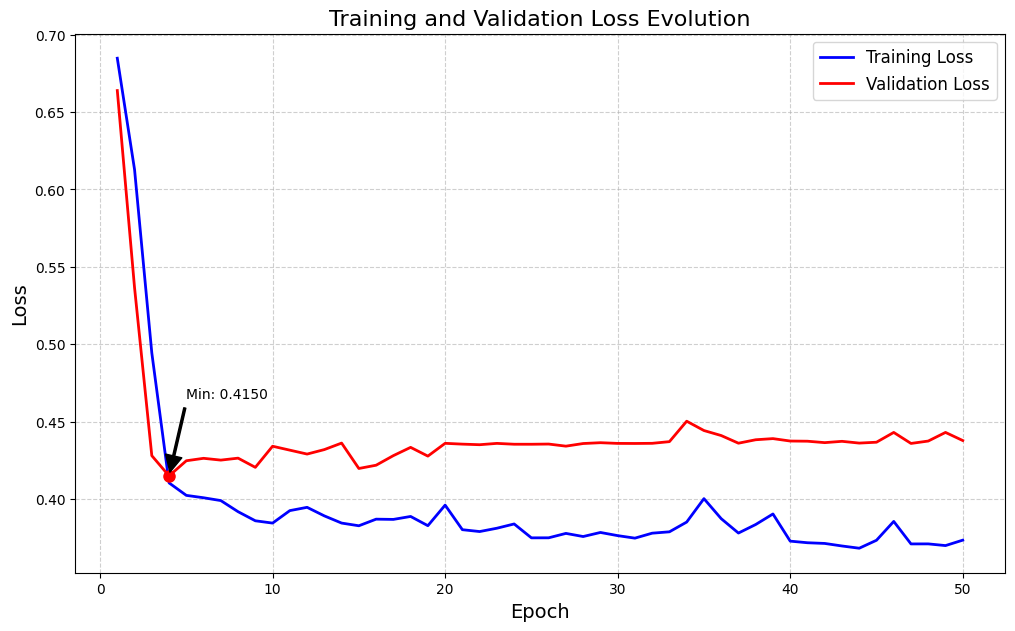

In [28]:
# Enhanced visualization of loss progression
plt.figure(figsize=(12, 7))
epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Validation Loss')

plt.title('Training and Validation Loss Evolution', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

min_val_loss = min(history['val_loss'])
min_val_epoch = history['val_loss'].index(min_val_loss) + 1
plt.plot(min_val_epoch, min_val_loss, 'ro', markersize=8)
plt.annotate(f'Min: {min_val_loss:.4f}', 
             xy=(min_val_epoch, min_val_loss),
             xytext=(min_val_epoch+1, min_val_loss+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

plt.show()

In [29]:
# Prediction on test set
model.eval()
nn_predicted = []
test_targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted_batch = torch.max(outputs, 1)
        _, labels_batch = torch.max(labels, 1)
        
        nn_predicted.extend(predicted_batch.cpu().numpy())
        test_targets.extend(labels_batch.numpy())

In [30]:
# Model evaluation
print("Neural Network Results:")
print(classification_report(test_targets, nn_predicted))

Neural Network Results:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        60
           1       0.91      0.87      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



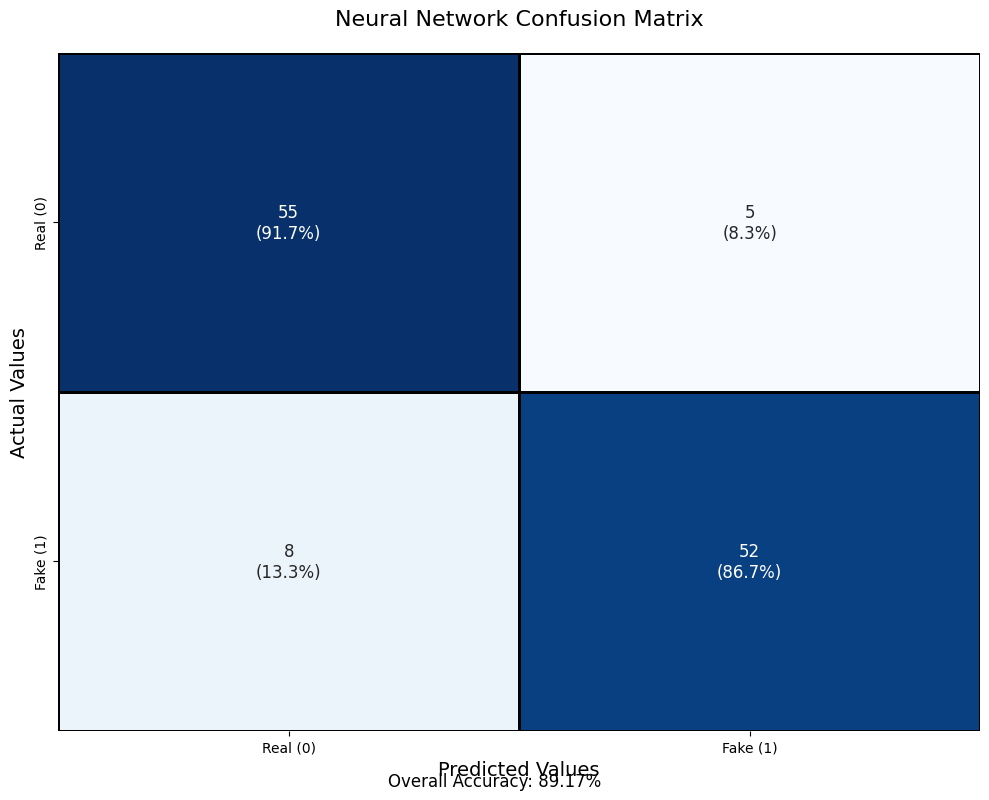

In [31]:
# Enhanced confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_targets, nn_predicted)
labels = ['Real (0)', 'Fake (1)']

# Calculate percentages for display
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Define custom annotations
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', linewidths=1, linecolor='black',
                 xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"size": 12})

plt.title('Neural Network Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Actual Values', fontsize=14)
plt.tight_layout()

# Add global accuracy
accuracy = np.trace(cm) / np.sum(cm) * 100
plt.figtext(0.5, 0.01, f'Overall Accuracy: {accuracy:.2f}%', ha='center', fontsize=12)

plt.show()

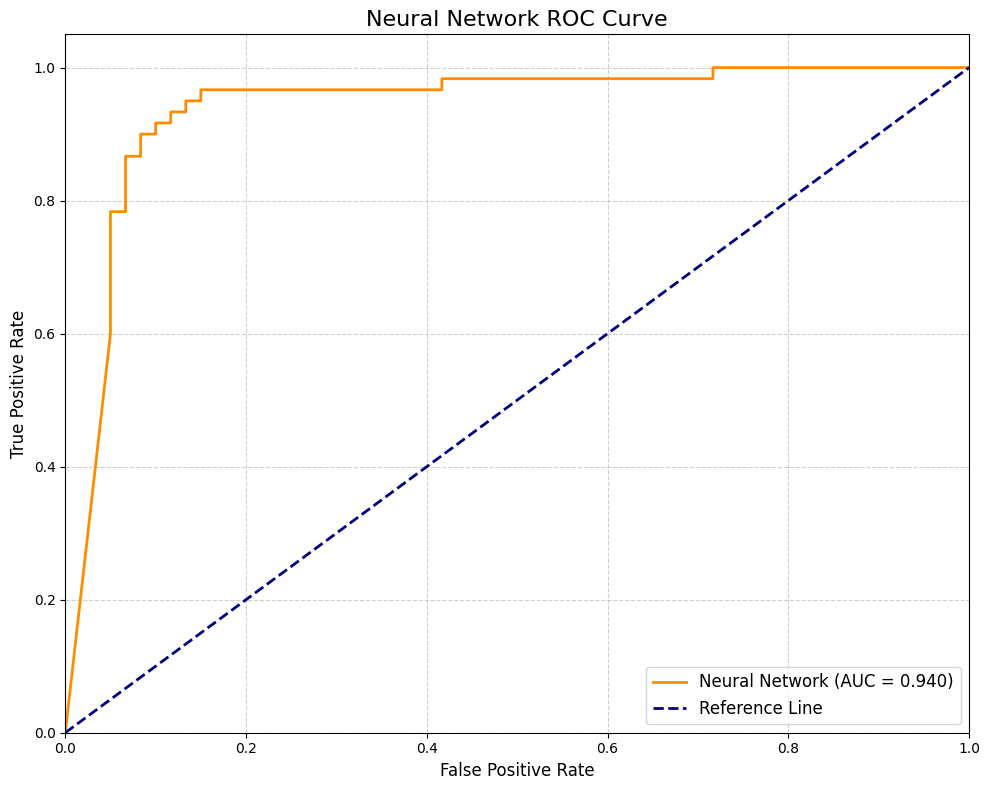

In [32]:
# ROC curve visualization
model.eval()
nn_y_true = []
nn_y_pred_proba = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        _, labels_batch = torch.max(labels, 1)
        nn_y_true.extend(labels_batch.numpy())
        nn_y_pred_proba.extend(outputs.cpu().numpy()[:, 1])

# Calculate the ROC curve
nn_fpr, nn_tpr, _ = roc_curve(nn_y_true, nn_y_pred_proba)
nn_roc_auc = metrics.auc(nn_fpr, nn_tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(nn_fpr, nn_tpr, color='darkorange', lw=2, label=f'Neural Network (AUC = {nn_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Reference Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Neural Network ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

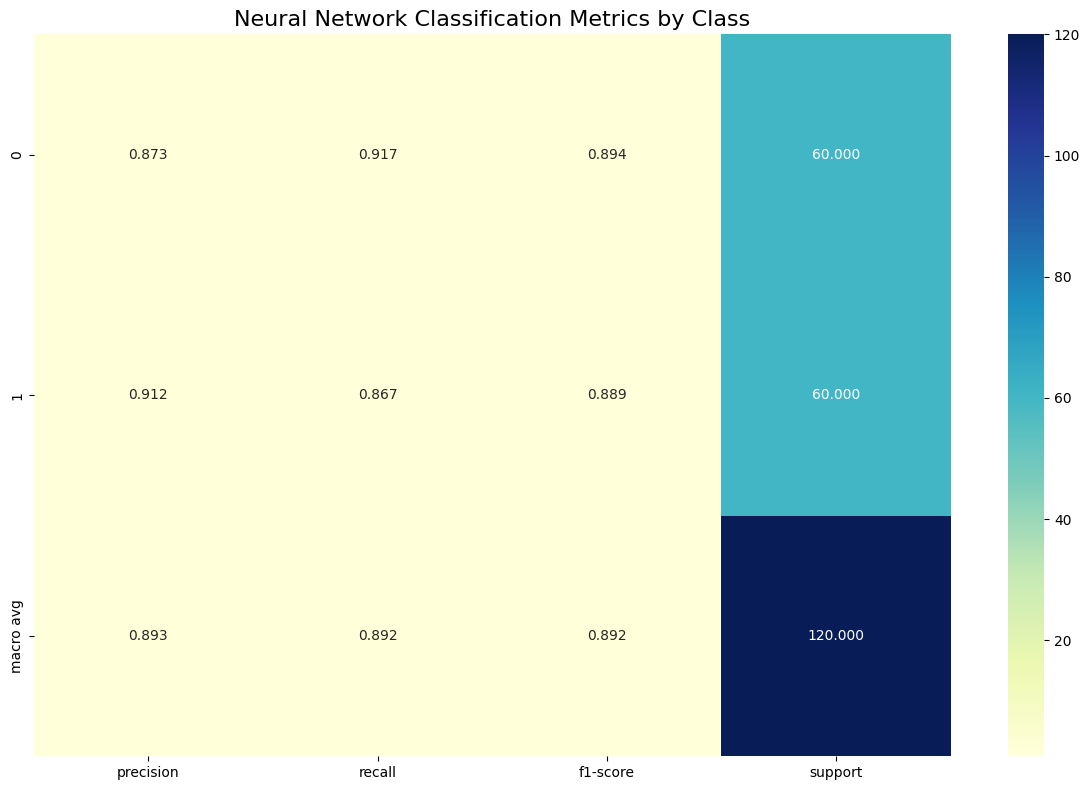

In [33]:
# Classification metrics visualization by class
nn_report = classification_report(test_targets, nn_predicted, output_dict=True)
nn_report_df = pd.DataFrame(nn_report).transpose()
nn_report_df = nn_report_df.drop('accuracy', errors='ignore')

plt.figure(figsize=(12, 8))
ax = sns.heatmap(nn_report_df.iloc[:-1, :].astype(float), annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Neural Network Classification Metrics by Class', fontsize=16)
plt.tight_layout()
plt.show()

# XGBoost Model

In [34]:
# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create a validation set for XGBoost
from sklearn.model_selection import train_test_split
X_train_raw = scaler_x.inverse_transform(X_train)  # Get unscaled features back
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_raw, y_train, test_size=0.1, random_state=42
)

# Train the model with early stopping
eval_set = [(X_val_xgb, y_val_xgb)]
xgb_model.fit(
    X_train_xgb, 
    y_train_xgb,
    eval_set=eval_set,
    verbose=True,
)

[0]	validation_0-logloss:0.63791
[1]	validation_0-logloss:0.58743
[2]	validation_0-logloss:0.54691
[3]	validation_0-logloss:0.51023
[4]	validation_0-logloss:0.48400
[5]	validation_0-logloss:0.45723
[6]	validation_0-logloss:0.43160
[7]	validation_0-logloss:0.41177
[8]	validation_0-logloss:0.38967
[9]	validation_0-logloss:0.37658
[10]	validation_0-logloss:0.36559
[11]	validation_0-logloss:0.34982
[12]	validation_0-logloss:0.34053
[13]	validation_0-logloss:0.33075
[14]	validation_0-logloss:0.32366
[15]	validation_0-logloss:0.31877
[16]	validation_0-logloss:0.31224
[17]	validation_0-logloss:0.30292
[18]	validation_0-logloss:0.29327
[19]	validation_0-logloss:0.28770
[20]	validation_0-logloss:0.28463
[21]	validation_0-logloss:0.27971
[22]	validation_0-logloss:0.27650
[23]	validation_0-logloss:0.26833
[24]	validation_0-logloss:0.26173
[25]	validation_0-logloss:0.25676
[26]	validation_0-logloss:0.25566
[27]	validation_0-logloss:0.25163
[28]	validation_0-logloss:0.24732
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

# XGBoost Model Validation and Results

In [35]:
# Get XGBoost predictions
X_test_raw = scaler_x.inverse_transform(X_test)  # Get unscaled features back
xgb_predicted = xgb_model.predict(X_test_raw)
xgb_predicted_proba = xgb_model.predict_proba(X_test_raw)[:, 1]

In [36]:
# Model evaluation
print("XGBoost Results:")
print(classification_report(y_test, xgb_predicted))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        60
           1       0.95      0.92      0.93        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120



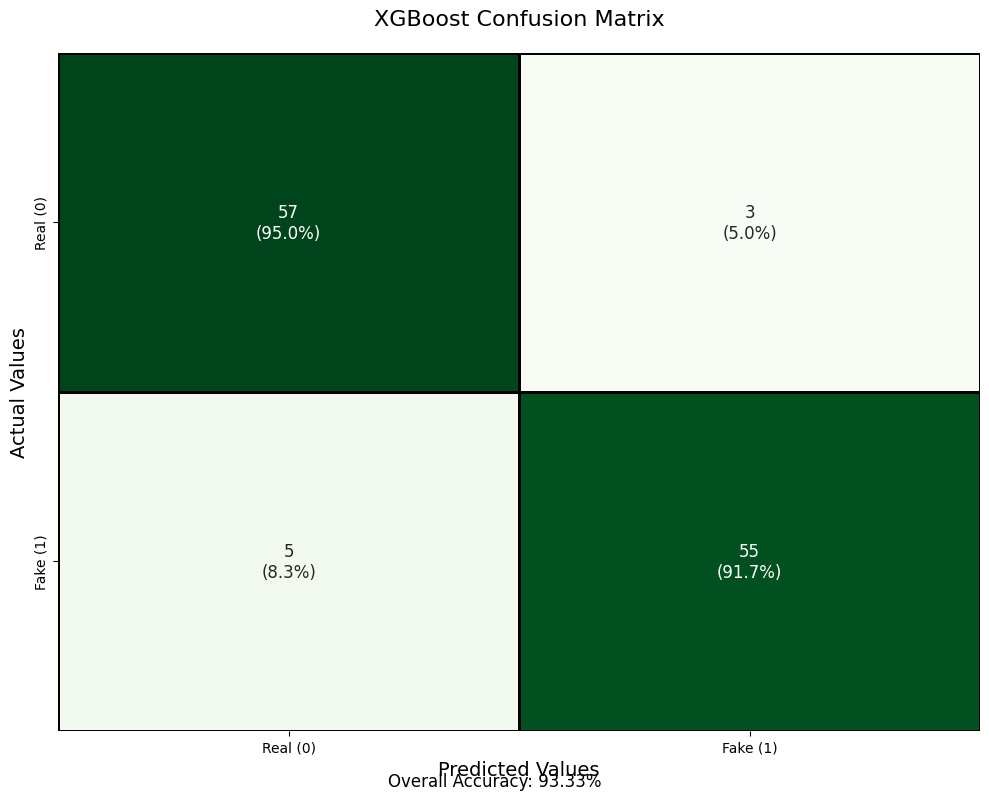

In [37]:
# XGBoost confusion matrix
plt.figure(figsize=(10, 8))
cm_xgb = confusion_matrix(y_test, xgb_predicted)
labels = ['Real (0)', 'Fake (1)']

# Calculate percentages for display
cm_percent_xgb = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis] * 100

# Define custom annotations
annot_xgb = np.empty_like(cm_xgb).astype(str)
for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        annot_xgb[i, j] = f'{cm_xgb[i, j]}\n({cm_percent_xgb[i, j]:.1f}%)'

ax = sns.heatmap(cm_xgb, annot=annot_xgb, fmt='', cmap='Greens', linewidths=1, linecolor='black',
                 xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"size": 12})

plt.title('XGBoost Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Actual Values', fontsize=14)
plt.tight_layout()

# Add global accuracy
accuracy_xgb = np.trace(cm_xgb) / np.sum(cm_xgb) * 100
plt.figtext(0.5, 0.01, f'Overall Accuracy: {accuracy_xgb:.2f}%', ha='center', fontsize=12)

plt.show()

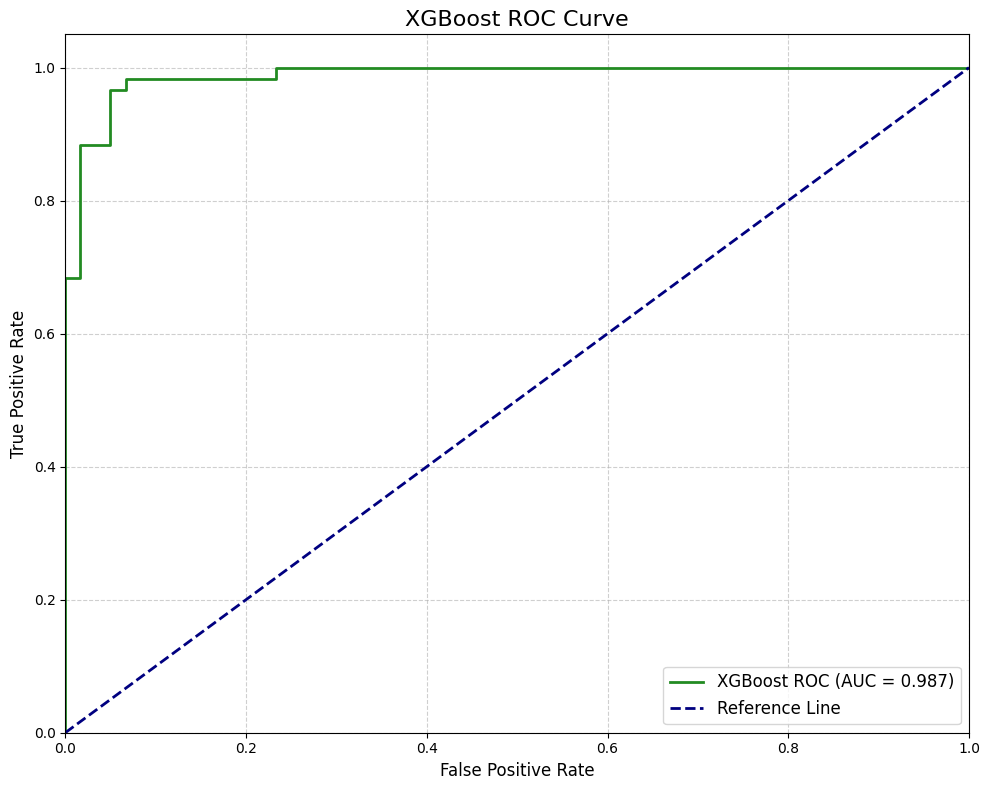

In [38]:
# XGBoost ROC curve
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_predicted_proba)
xgb_roc_auc = metrics.auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 8))
plt.plot(xgb_fpr, xgb_tpr, color='forestgreen', lw=2, label=f'XGBoost ROC (AUC = {xgb_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Reference Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('XGBoost ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

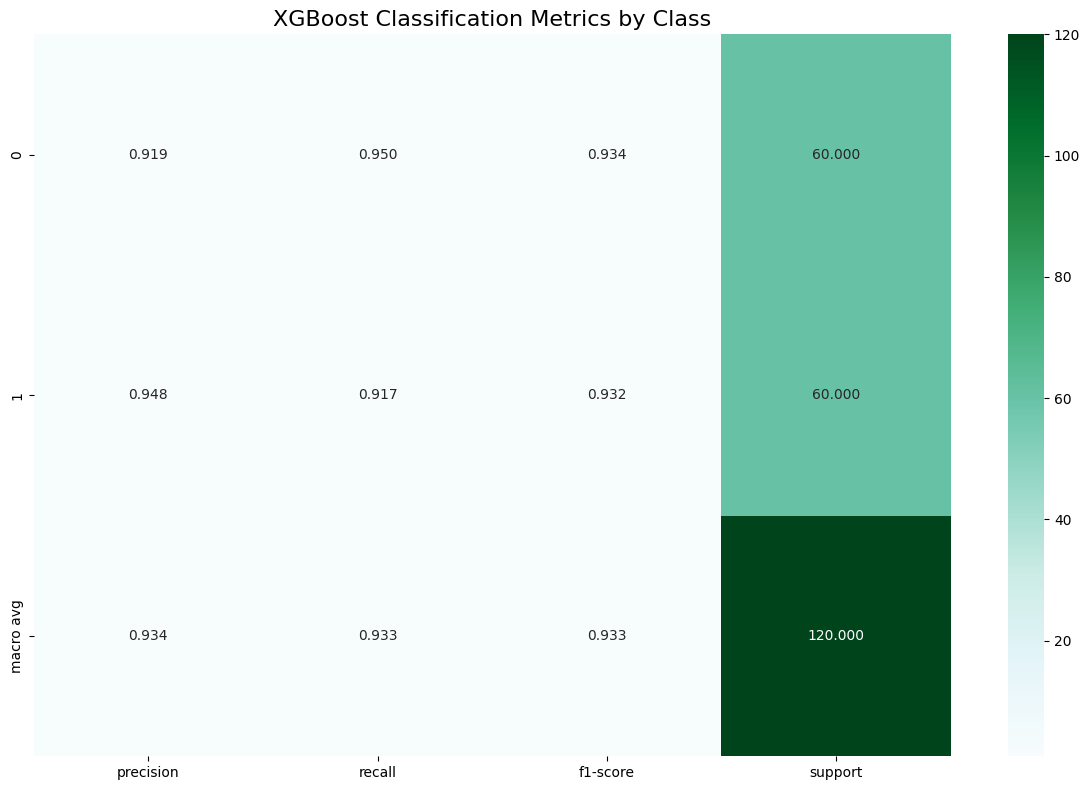

In [39]:
# XGBoost classification metrics by class
xgb_report = classification_report(y_test, xgb_predicted, output_dict=True)
xgb_report_df = pd.DataFrame(xgb_report).transpose()
xgb_report_df = xgb_report_df.drop('accuracy', errors='ignore')

plt.figure(figsize=(12, 8))
ax = sns.heatmap(xgb_report_df.iloc[:-1, :].astype(float), annot=True, cmap='BuGn', fmt='.3f')
plt.title('XGBoost Classification Metrics by Class', fontsize=16)
plt.tight_layout()
plt.show()

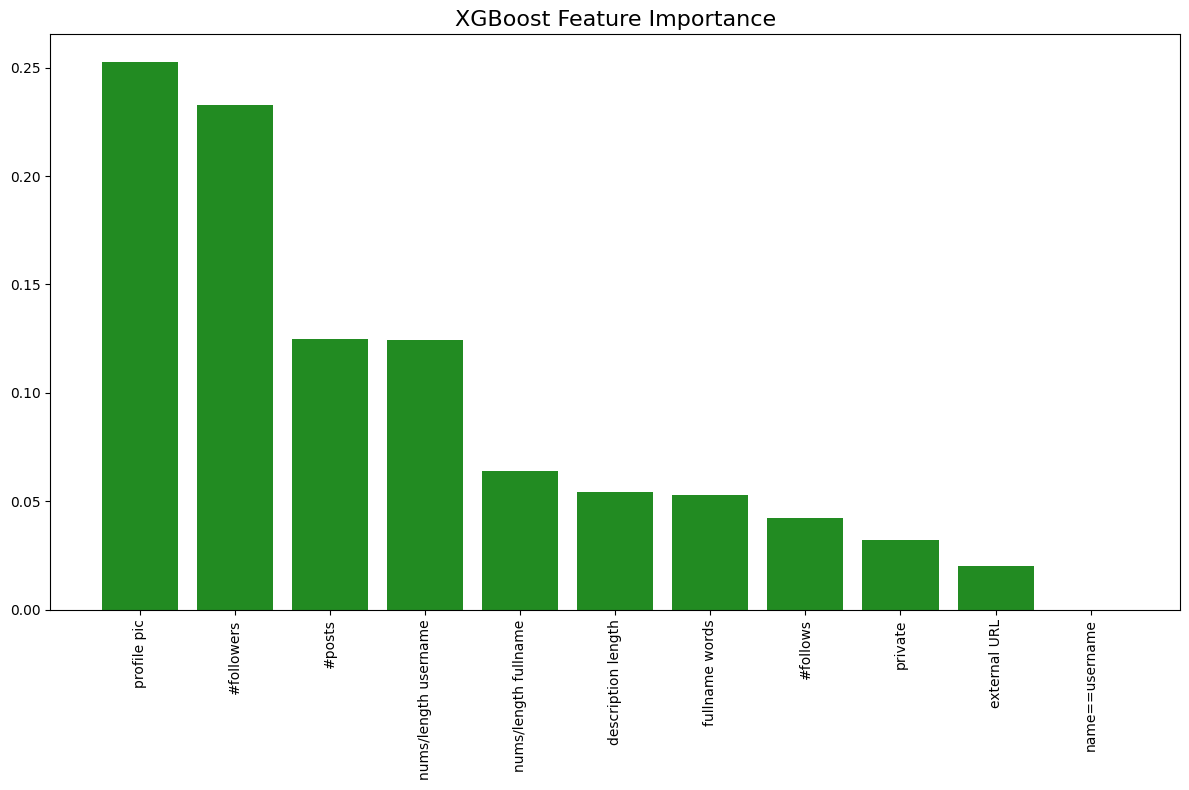

In [40]:
# Feature importance visualization for XGBoost
plt.figure(figsize=(12, 8))
feature_names = instagram_df_train.drop(columns=['fake']).columns
xgb_importance = xgb_model.feature_importances_
indices = np.argsort(xgb_importance)[::-1]

plt.title('XGBoost Feature Importance', fontsize=16)
plt.bar(range(len(xgb_importance)), xgb_importance[indices], color='forestgreen', align='center')
plt.xticks(range(len(xgb_importance)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Model Comparison

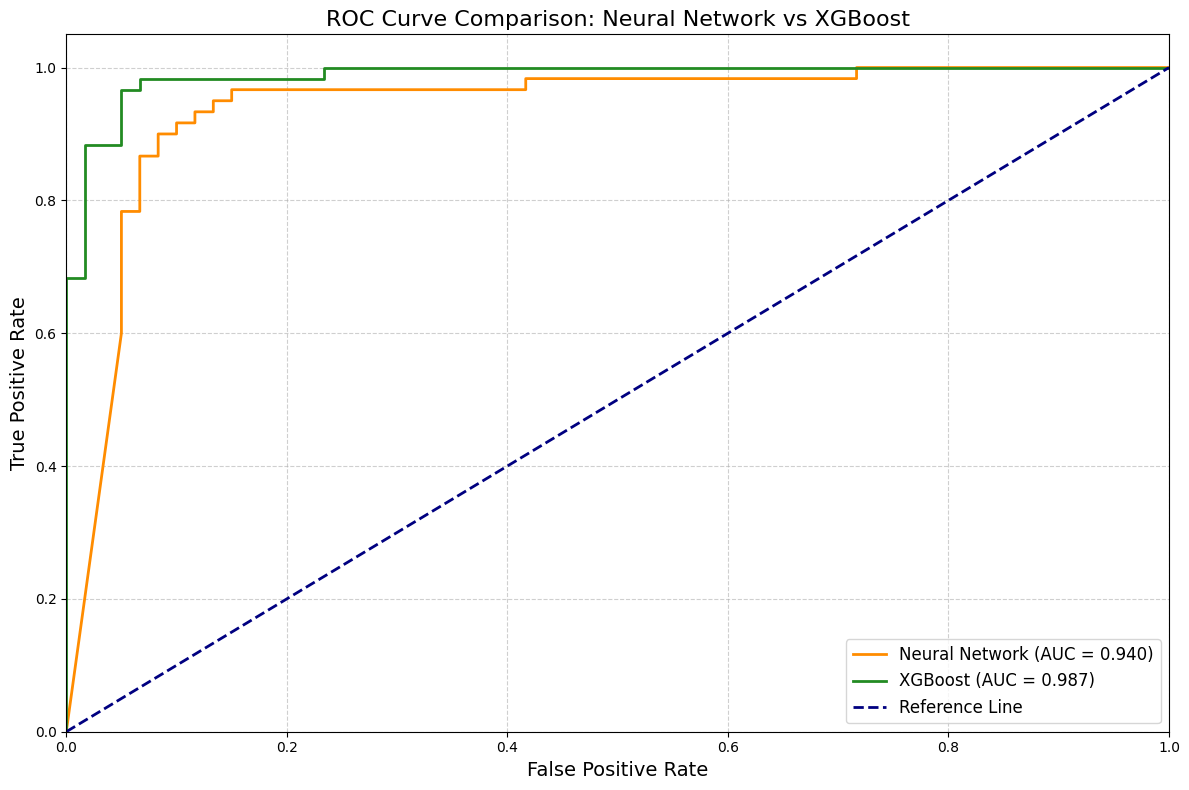

In [41]:
# Compare ROC curves of both models
plt.figure(figsize=(12, 8))
plt.plot(nn_fpr, nn_tpr, 'darkorange', lw=2, label=f'Neural Network (AUC = {nn_roc_auc:.3f})')
plt.plot(xgb_fpr, xgb_tpr, 'forestgreen', lw=2, label=f'XGBoost (AUC = {xgb_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--', label='Reference Line')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison: Neural Network vs XGBoost', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


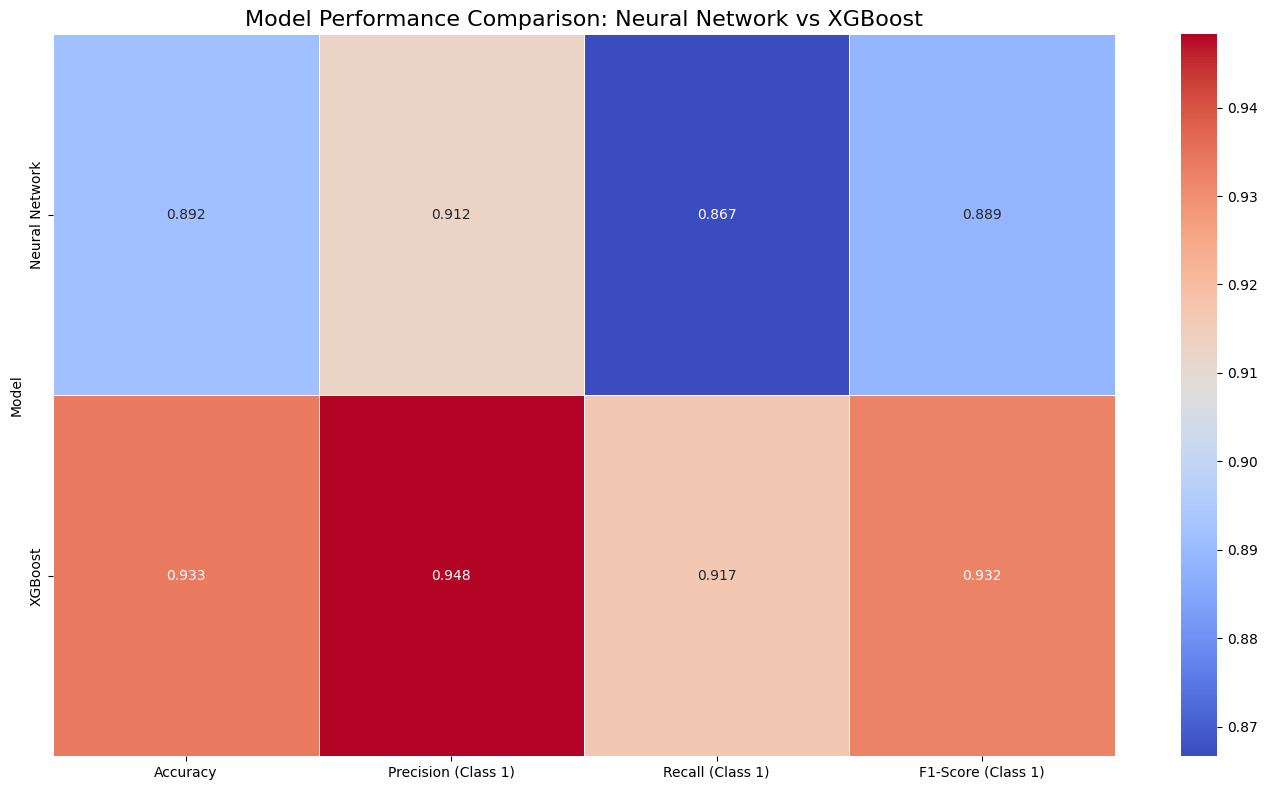

In [42]:
# Compare accuracy, precision, recall, and F1-score for both models
metrics_comparison = pd.DataFrame({
    'Model': ['Neural Network', 'XGBoost'],
    'Accuracy': [accuracy_score(test_targets, nn_predicted), accuracy_score(y_test, xgb_predicted)],
    'Precision (Class 1)': [nn_report['1']['precision'], xgb_report['1']['precision']],
    'Recall (Class 1)': [nn_report['1']['recall'], xgb_report['1']['recall']],
    'F1-Score (Class 1)': [nn_report['1']['f1-score'], xgb_report['1']['f1-score']],
})

metrics_comparison.set_index('Model', inplace=True)

plt.figure(figsize=(14, 8))
ax = sns.heatmap(metrics_comparison, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title('Model Performance Comparison: Neural Network vs XGBoost', fontsize=16)
plt.tight_layout()
plt.show()

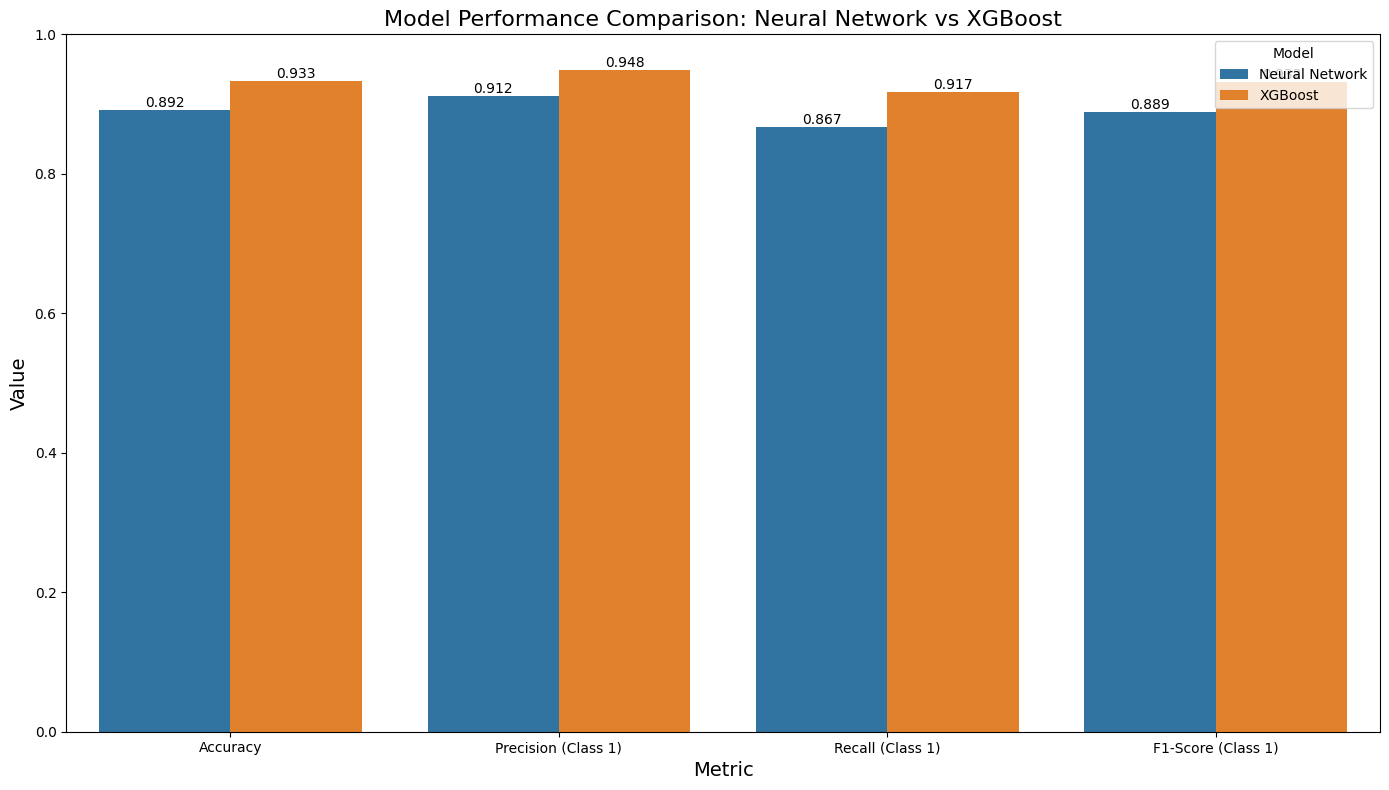

In [43]:
# Bar chart comparison of key metrics
metrics_df_melted = pd.melt(metrics_comparison.reset_index(), id_vars=['Model'])

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='variable', y='value', hue='Model', data=metrics_df_melted)
plt.title('Model Performance Comparison: Neural Network vs XGBoost', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(title='Model')
plt.ylim(0, 1.0)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10)

plt.tight_layout()
plt.show()